# Step 1: Setup & Data Exploration

Loaded 444 annotated images.


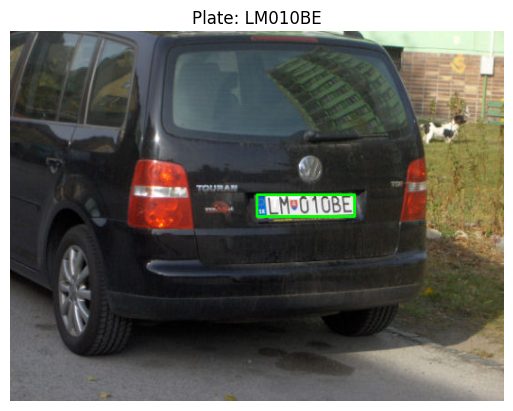

In [1]:
import os
from pathlib import Path
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

# Define path to the Total folder
DATA_PATH = Path(r"C:\ULB\MA1\Proj\PROJ-H419\proj-h419-lisence_plates_car_detection\Code\Data\Total")

# Prepare a list to collect the dataset records
dataset = []

# 1) Loop through all files in the folder
for file in DATA_PATH.iterdir():
    if file.suffix == ".txt":
        with open(file, 'r') as f:
            line = f.readline().strip()
            parts = line.split('\t')

            if len(parts) != 6:
                print(f"Skipping malformed file: {file.name}")
                continue

            img_name, x, y, w, h, plate_text = parts
            img_path = DATA_PATH / img_name

            if not img_path.exists():
                print(f"Image not found for annotation: {img_name}")
                continue

            dataset.append({
                "image_path": str(img_path),
                "x": int(x),
                "y": int(y),
                "w": int(w),
                "h": int(h),
                "plate_text": plate_text
            })

# 2) Convert to DataFrame
df = pd.DataFrame(dataset)
print(f"Loaded {len(df)} annotated images.")

# 3) Visualize a sample
sample = df.iloc[199]
img = cv2.imread(sample["image_path"])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw bounding box
x, y, w, h = sample["x"], sample["y"], sample["w"], sample["h"]
cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(img_rgb)
plt.title(f"Plate: {sample['plate_text']}")
plt.axis('off')
plt.show()

# Step 2: Data Preprocessing


In [2]:
# Constants
IMAGE_SIZE = (416, 416)  # (width, height)

# Lists to hold results
processed_images = []
processed_bboxes = []

# Loop through the dataset
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        # Load image
        img = cv2.imread(row["image_path"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_height, orig_width = img.shape[:2]

        # Resize image because NN need consistent input size
        img_resized = cv2.resize(img, IMAGE_SIZE, interpolation=cv2.INTER_AREA) # We changed the default resize methode (Inter_Linear) with Inter_Area to conserve more the quality of the image once resized

        # Normalize pixel values [0, 1], it makes training faster
        img_normalized = img_resized.astype("float32") / 255.0

        # Rescale and normalize bounding box
        x_scale = IMAGE_SIZE[0] / orig_width
        y_scale = IMAGE_SIZE[1] / orig_height

        x = row["x"] * x_scale
        y = row["y"] * y_scale
        w = row["w"] * x_scale
        h = row["h"] * y_scale

        bbox_normalized = [
            x / IMAGE_SIZE[0],
            y / IMAGE_SIZE[1],
            w / IMAGE_SIZE[0],
            h / IMAGE_SIZE[1]
        ]

        # Store result
        processed_images.append(img_normalized)
        processed_bboxes.append(bbox_normalized)

    except Exception as e:
        print(f"Error processing {row['image_path']}: {e}")
        continue

# Convert to NumPy arrays
X = np.array(processed_images)
y = np.array(processed_bboxes)

print(f"Processed {len(X)} images.")
print("Image shape:", X[0].shape)
print("Sample bounding box:", y[0])

100%|██████████| 444/444 [00:18<00:00, 23.54it/s]


Processed 444 images.
Image shape: (416, 416, 3)
Sample bounding box: [0.48697917 0.33518519 0.0515625  0.04537037]


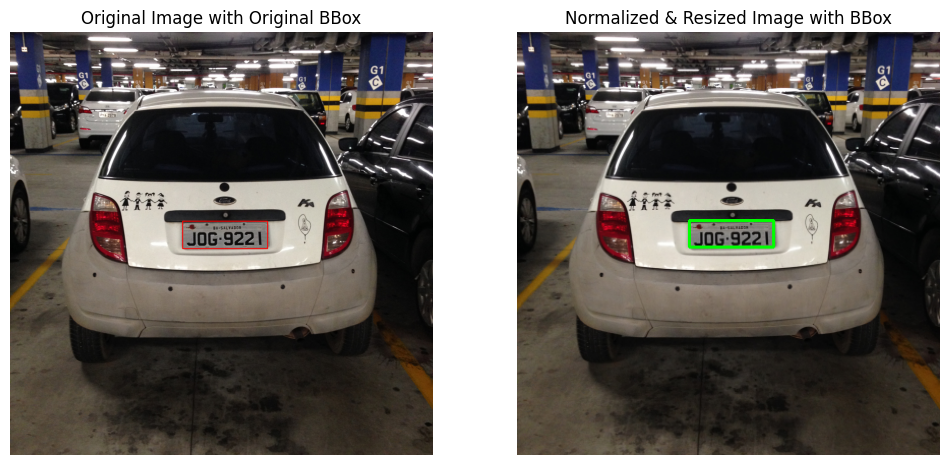

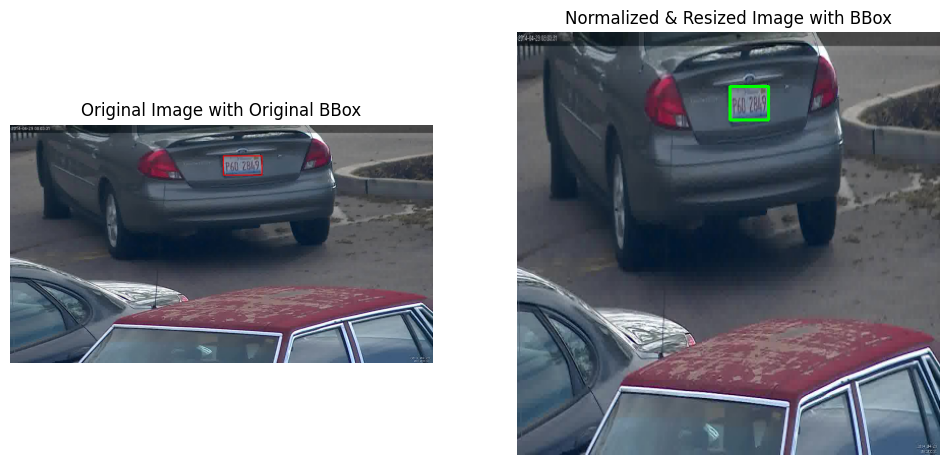

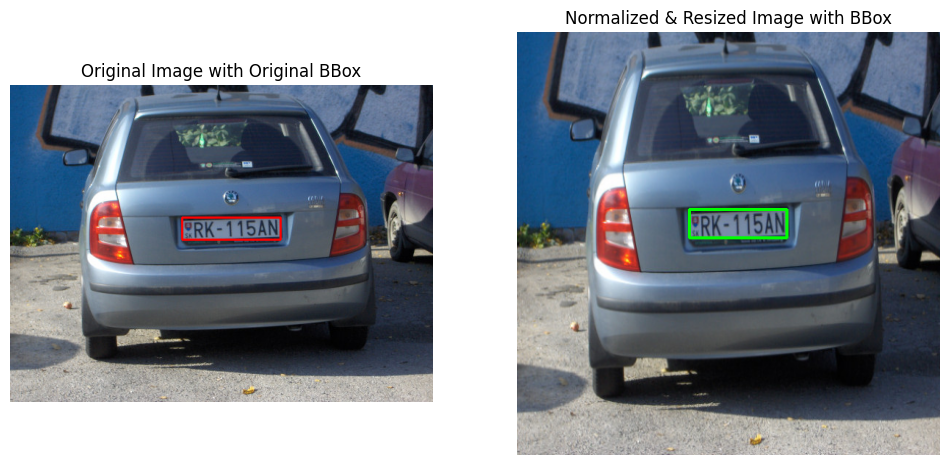

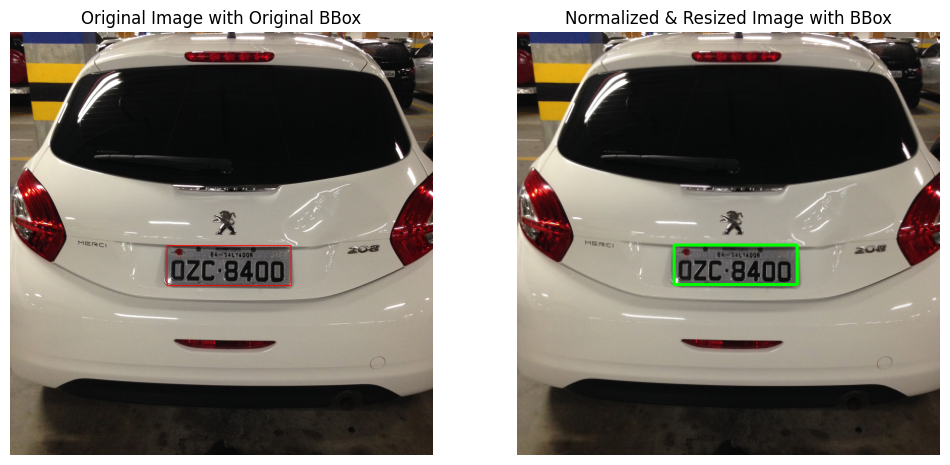

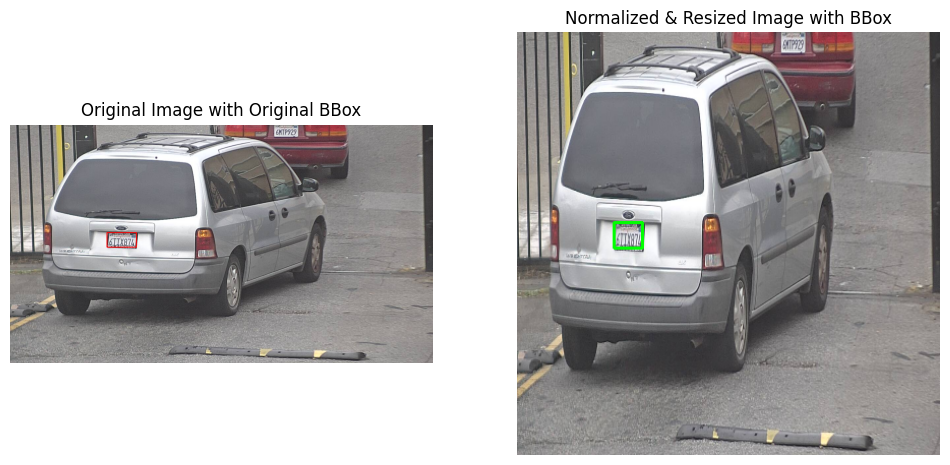

In [3]:
# Visualize a sample to see the difference between an original image and a preprocessed one
def visualize_sample(index=199):
    try:
        img_normalized = X[index]
        bbox_norm = y[index]  # <-- Changed variable name to avoid conflict
        original_row = df.iloc[index]

        # Load the original image
        img_original = cv2.imread(original_row["image_path"])
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

        # Draw original bbox
        x_orig, y_orig, w_orig, h_orig = (original_row["x"], original_row["y"], original_row["w"], original_row["h"])
        img_original_vis = img_original.copy()
        cv2.rectangle(img_original_vis, (x_orig, y_orig), (x_orig + w_orig, y_orig + h_orig), (255, 0, 0), 2)

        # Prepare normalized image
        img_vis = (img_normalized * 255).astype(np.uint8).copy()
        x_norm = int(bbox_norm[0] * IMAGE_SIZE[0])
        y_norm = int(bbox_norm[1] * IMAGE_SIZE[1])
        w_norm = int(bbox_norm[2] * IMAGE_SIZE[0])
        h_norm = int(bbox_norm[3] * IMAGE_SIZE[1])
        cv2.rectangle(img_vis, (x_norm, y_norm), (x_norm + w_norm, y_norm + h_norm), (0, 255, 0), 2)

        # Plot side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(img_original_vis)
        axs[0].set_title('Original Image with Original BBox')
        axs[0].axis('off')

        axs[1].imshow(img_vis)
        axs[1].set_title('Normalized & Resized Image with BBox')
        axs[1].axis('off')

        plt.show()

    except IndexError:
        print(f"Index {index} is out of bounds. Please choose an index between 0 and {len(X)-1}.")
    except Exception as e:
        print(f"Error visualizing sample at index {index}: {e}")

def visualize_multiple_samples(num_samples=5):
    """
    Randomly visualize multiple samples from the dataset.
    """
    try:
        indices = random.sample(range(len(X)), num_samples)

        for idx in indices:
            visualize_sample(idx)

    except ValueError:
        print(f"Requested {num_samples} samples, but dataset only has {len(X)} images.")
    except Exception as e:
        print(f"Error during multiple visualization: {e}")

visualize_multiple_samples(5)

## Here we want to benchmark the benchmark image quality side-by-side using INTER_LINEAR vs INTER_AREA

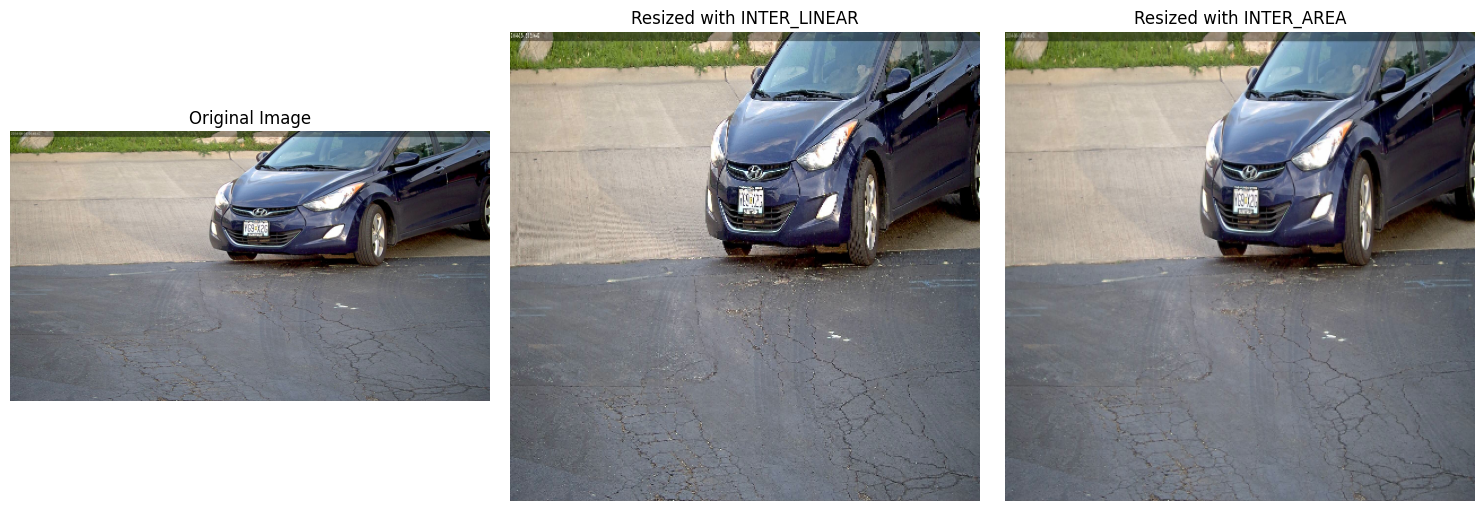

In [4]:
def compare_resize_methods(index=0):
    """
    Compare image quality between INTER_LINEAR and INTER_AREA interpolation.
    """
    try:
        # Load original image
        original_row = df.iloc[index]
        img_path = original_row["image_path"]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize with INTER_LINEAR (default)
        resized_linear = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

        # Resize with INTER_AREA (better for downscaling)
        resized_area = cv2.resize(img_rgb, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

        # Plot side-by-side
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(img_rgb)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(resized_linear)
        axs[1].set_title("Resized with INTER_LINEAR")
        axs[1].axis('off')

        axs[2].imshow(resized_area)
        axs[2].set_title("Resized with INTER_AREA")
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error comparing resize methods at index {index}: {e}")

compare_resize_methods(0)

# Step 3: Building a Detection Model


In [ ]:
def create_license_plate_detector_cnn(input_shape=(416, 416, 3)):
    model = keras.Sequential([
        # Input Layer - accepts your images
        keras.layers.Input(shape=input_shape),

        # First Convolutional Block - detects basic features
        keras.layers.Conv2D(32, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),  # stabilizes training
        keras.layers.Activation('relu'),    # adds non-linearity
        keras.layers.MaxPooling2D((2, 2)),  # reduces dimensions by half

        # Second Convolutional Block - detects more complex features
        keras.layers.Conv2D(64, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block - higher-level features
        keras.layers.Conv2D(128, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),

        # Fourth Convolutional Block - even more abstract features
        keras.layers.Conv2D(256, (3, 3), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.MaxPooling2D((2, 2)),

        # Flatten the output (feature maps) to feed into dense layers
        keras.layers.Flatten(),

        # Fully Connected Layers - for bounding box regression
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),  # prevents overfitting
        keras.layers.Dense(128, activation='relu'),

        # Output Layer - 4 values for the bounding box coordinates
        keras.layers.Dense(4, activation='sigmoid')  # sigmoid ensures values 0-1
    ])

    # Custom IoU metric for bounding box predictions
    def iou_metric(y_true, y_pred):
        # Extract coordinates from tensors
        # For true bounding boxes
        x_true, y_true, w_true, h_true = [
            y_true[:, i] for i in range(4)
        ]
        x1_true, y1_true = x_true, y_true
        x2_true, y2_true = x1_true + w_true, y1_true + h_true

        # For predicted bounding boxes
        x_pred, y_pred, w_pred, h_pred = [
            y_pred[:, i] for i in range(4)
        ]
        x1_pred, y1_pred = x_pred, y_pred
        x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred

        # Calculate area of true and predicted boxes
        area_true = w_true * h_true
        area_pred = w_pred * h_pred

        # Calculate intersection coordinates
        x1_intersect = keras.backend.maximum(x1_true, x1_pred)
        y1_intersect = keras.backend.maximum(y1_true, y1_pred)
        x2_intersect = keras.backend.minimum(x2_true, x2_pred)
        y2_intersect = keras.backend.minimum(y2_true, y2_pred)

        # Calculate intersection width and height (clipped at 0)
        w_intersect = keras.backend.maximum(0.0, x2_intersect - x1_intersect)
        h_intersect = keras.backend.maximum(0.0, y2_intersect - y1_intersect)

        # Calculate intersection area
        area_intersect = w_intersect * h_intersect

        # Calculate union area
        area_union = area_true + area_pred - area_intersect

        # Calculate IoU
        iou = area_intersect / (area_union + keras.backend.epsilon())

        # Return mean IoU across the batch
        return keras.backend.mean(iou)

    # Compile the model with Huber loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.Huber(),  # Huber loss is more robust to outliers than MSE
        metrics=['mae', iou_metric]  # Track both MAE and IoU
    )

    return model

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# Create model
model = create_license_plate_detector_cnn()
model.summary()

In [ ]:
# Define callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  # stop when not improving
    keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3),  # reduce learning rate when plateauing
    keras.callbacks.ModelCheckpoint('license_plate_detector.h5', save_best_only=True)  # save best model
]

Training samples: 355, Validation samples: 89


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 416, 416, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 416, 416, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 416, 416, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 208, 208, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 208, 208, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 104, 104, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 104, 104, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 104, 104, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 52, 52, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,605,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,061,700 (339.74 MB)

 Trainable params: 89,060,740 (339.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - loss: 0.1523 - mae: 0.3121  

12/12 ━━━━━━━━━━━━━━━━━━━━ 947s 76s/step - loss: 0.1513 - mae: 0.3110 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 0.0010
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 303s 21s/step - loss: 0.1294 - mae: 0.2887 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 0.0010
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 343s 28s/step - loss: 0.1283 - mae: 0.2879 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 0.0010
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 350s 29s/step - loss: 0.1269 - mae: 0.2860 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 0.0010
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 367s 30s/step - loss: 0.1238 - mae: 0.2831 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 2.0000e-04
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 435s 36s/step - loss: 0.1265 - mae: 0.2851 - val_loss: 0.1200 - val_mae: 0.2779 - learning_rate: 2.0000e-04


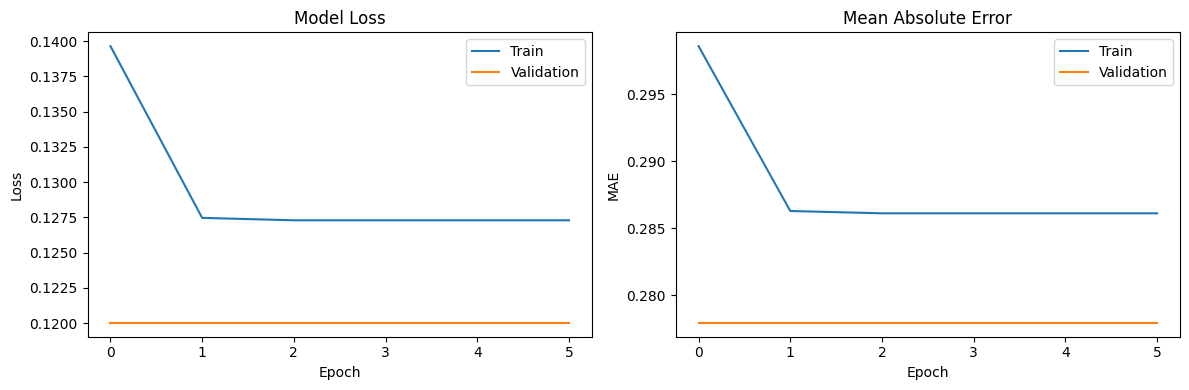

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Plot training & validation loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss (Huber)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation mean absolute error
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation IoU
    plt.subplot(1, 3, 3)
    plt.plot(history.history['iou_metric'])
    plt.plot(history.history['val_iou_metric'])
    plt.title('Intersection over Union')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Step 5: Model Evaluation and Utilization

## Using both MAE and IoU metrics for comprehensive evaluation


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


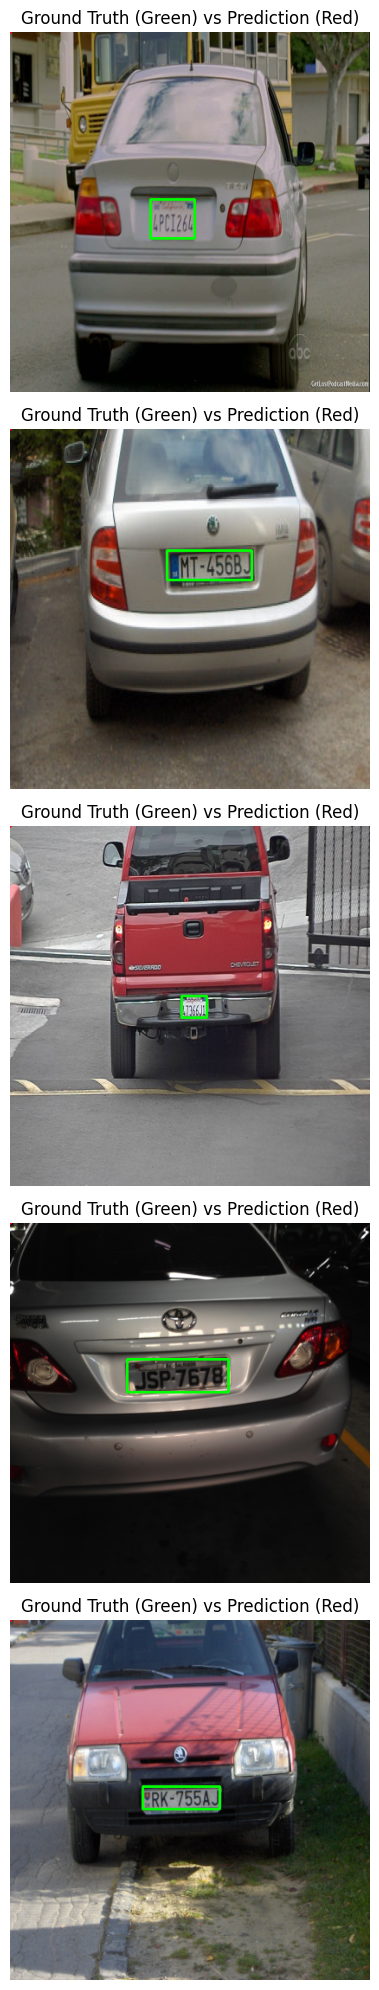

In [ ]:
# Function to evaluate model performance
def evaluate_license_plate_detection(model, X_val, y_val, num_samples=5):
    # Select random samples for visualization
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    plt.figure(figsize=(15, 4*num_samples))
    
    # List to store IoU values
    iou_values = []

    for i, idx in enumerate(indices):
        # Get image and ground truth
        img = X_val[idx]
        true_bbox = y_val[idx]

        # Make prediction
        pred_bbox = model.predict(np.expand_dims(img, axis=0))[0]

        # Convert normalized coordinates to pixel coordinates
        h, w = IMAGE_SIZE

        # Ground truth bbox (green)
        true_x = int(true_bbox[0] * w)
        true_y = int(true_bbox[1] * h)
        true_width = int(true_bbox[2] * w)
        true_height = int(true_bbox[3] * h)

        # Predicted bbox (red)
        pred_x = int(pred_bbox[0] * w)
        pred_y = int(pred_bbox[1] * h)
        pred_width = int(pred_bbox[2] * w)
        pred_height = int(pred_bbox[3] * h)
        
        # Calculate IoU for this sample
        # 1. Calculate box coordinates
        true_x1, true_y1 = true_x, true_y
        true_x2, true_y2 = true_x + true_width, true_y + true_height
        
        pred_x1, pred_y1 = pred_x, pred_y
        pred_x2, pred_y2 = pred_x + pred_width, pred_y + pred_height
        
        # 2. Calculate intersection coordinates
        x1_intersect = max(true_x1, pred_x1)
        y1_intersect = max(true_y1, pred_y1)
        x2_intersect = min(true_x2, pred_x2)
        y2_intersect = min(true_y2, pred_y2)
        
        # 3. Calculate intersection area (handle case where boxes don't overlap)
        w_intersect = max(0, x2_intersect - x1_intersect)
        h_intersect = max(0, y2_intersect - y1_intersect)
        area_intersect = w_intersect * h_intersect
        
        # 4. Calculate union area
        area_true = true_width * true_height
        area_pred = pred_width * pred_height
        area_union = area_true + area_pred - area_intersect
        
        # 5. Calculate IoU
        iou = area_intersect / area_union if area_union > 0 else 0
        iou_values.append(iou)

        # Create a copy of the image for visualization
        img_vis = (img * 255).astype(np.uint8).copy()

        # Draw bounding boxes
        cv2.rectangle(img_vis, (true_x, true_y),
                      (true_x + true_width, true_y + true_height),
                      (0, 255, 0), 2)  # true = green

        cv2.rectangle(img_vis, (pred_x, pred_y),
                      (pred_x + pred_width, pred_y + pred_height),
                      (255, 0, 0), 2)  # predicted = red

        # Display image
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img_vis)
        plt.title(f'Ground Truth (Green) vs Prediction (Red) - IoU: {iou:.4f}')
        plt.axis('off')
    
    # Print average IoU
    mean_iou = np.mean(iou_values)
    print(f"Average IoU on {num_samples} samples: {mean_iou:.4f}")

    plt.tight_layout()
    plt.show()

# Evaluate on validation data
evaluate_license_plate_detection(model, X_val, y_val)

# Function to detect license plates in new images
def detect_license_plate(model, image_path):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    # Resize and normalize for model input
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    img_normalized = img_resized / 255.0

    # Make prediction
    prediction = model.predict(np.expand_dims(img_normalized, axis=0))[0]

    # Convert normalized coordinates back to original image size
    x_pred, y_pred, w_pred, h_pred = prediction
    x = int(x_pred * orig_w)
    y = int(y_pred * orig_h)
    width = int(w_pred * orig_w)
    height = int(h_pred * orig_h)

    # Draw detection on image
    result_img = img_rgb.copy()
    cv2.rectangle(result_img, (x, y), (x + width, y + height), (0, 255, 0), 2)

    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(result_img)
    plt.axis('off')
    plt.title("License Plate Detection")
    plt.show()

    # Extract the detected license plate region
    plate_region = img_rgb[y:y + height, x:x + width]

    return plate_region, [x, y, width, height]